# IBM Data Science Capstone Project

By Jonathan de Steuben

## Introduction:

In this project, we will identify areas within Washington, D.C. that would benefit from the placement of various medical facilities. The target audiences for this report will be local health officials, local elected officials, and healthcare providers.

While there are existing medical facilities in Washington, D.C., this report will aim to locate areas within the city that have a smaller concentration as well as areas that could be considered underserved. We will determine what type of facility would best fit the area and make an appropriate recommendation.

## Data:

Based on the description of the problem, this report will leverage open data provided by different sources. The following factors will influence the recommendations that will be made:

* Demographic data for Washington, D.C. wards
* Number of medical facilities within each ward
* Type of medical facilities

For this project, we will examine neighborhoods at the ward level. The following sources will be used to generate our data and subsequent recommendations:

* [Urban Institute](https://greaterdc.urban.org/data-explorer?geography=cl17) - ward demographic data
* [Washington, D.C. Open Data](https://opendata.dc.gov/) - geoJSON files for visualization
* [Foursquare API](https://developer.foursquare.com/docs/resources/categories) - location data for medical facilities

### 1. Neighborhood Data:

We will use the coordinates of neighborhoods to find medical facilities within a specific range. We'll use the neighborhood coordinates to visualize some of the data. After this, we will use these coordinates to find facilities in targeted areas.

The data will work in tandem with data at the ward level. Washington, D.C. doesn't collect demographic data at the neighborhood level, so our recommendation will be contingent on information we get from each ward.

In [32]:
# Accessed with Washington, D.C. open data
import pandas as pd

neighborhoods = pd.read_excel('DC_Neighborhoods_Data.xlsx')

neighborhoods.head()

,OBJECTID,GIS_ID,NAME,WEB_URL,LABEL_NAME,DATELASTMODIFIED,X,Y,LON,LAT,WARD
0,1,nhood_050,Fort Stanton,http://NeighborhoodAction.dc.gov,Fort Stanton,2003-04-10T00:00:00.000Z,-76.980348,38.855658,-76.980348,38.855658,8
1,2,nhood_031,Congress Heights,http://NeighborhoodAction.dc.gov,Congress Heights,2003-04-10T00:00:00.000Z,-76.997950,38.841077,-76.997950,38.841077,8
2,3,nhood_123,Washington Highlands,http://NeighborhoodAction.dc.gov,Washington Highlands,2003-04-10T00:00:00.000Z,-76.995636,38.830237,-76.995636,38.830237,8
3,4,nhood_008,Bellevue,http://NeighborhoodAction.dc.gov,Bellevue,2003-04-10T00:00:00.000Z,-77.009271,38.826952,-77.009271,38.826952,8
4,5,nhood_073,Knox Hill/Buena Vista,http://NeighborhoodAction.dc.gov,Knox Hill/Buena Vista,2003-04-10T00:00:00.000Z,-76.967660,38.853688,-76.967660,38.853688,8


In [33]:
neighborhoods.shape

(132, 11)

Now that we have our neighborhood data imported, let's visualize their points and import additional packages.

In [34]:
# Visualizing the neighborhood data
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import seaborn as sns

In [35]:
#Obtaining coordinates for Washington, D.C.
address = 'Washington, D.C.'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Washington, D.C. are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Washington, D.C. are 38.8948932, -77.0365529.


Given the coordinates for the District, we'll create variables for our visualizations.

In [143]:
#Visualizing the neighborhood points with a border layer for the city.
DC_LAT = 38.895
DC_LON = -77.0366

ward = r'dc_ward_overlay.geojson'

dc_map = folium.Map(location=[DC_LAT, DC_LON], tiles='CartoDB positron', zoom_start=11.5)

folium.GeoJson(ward, name='geojson').add_to(dc_map)

for lat, lng, name, ward in zip(neighborhoods['LAT'], neighborhoods['LON'], neighborhoods['NAME'], neighborhoods['WARD']):
    label = '{}, Ward: {}'.format(name, ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.7,
        parse_html=False).add_to(dc_map)
    
dc_map    

Above, we've produced a folium visualization of Washington, D.C. and it's neighborhoods. Readers are encouraged to explore the map.

Looking at this visualization, we can see that most of the neighborhoods fit nicely within the ward borders we've added. Some are very close to borders, but it should be noted that Washington, D.C. neighborhood labels aren't exactly precise. This is because the District's smallest administrative regions (where data is collected) comes from the wards.

In [136]:
#Saving map to HTML:
dc_map.save('DC_Map.html')


### 2. Demographic Data:

Now that we've loaded our neighborhood coordinate data, we'll import files containing information accessed from the Urban Institue. The data includes information on population size and income.

Using this data, we will look at look for wards that have a higher percentage of poor residents.

In [37]:
#Importing packages to examine and plot the demographic data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Both of these files were provided by the Urban Institute's Greater DC data explorer:

In [38]:
#Loading demographic data provided by the Urban Institue

population = pd.read_excel('population_wd12.xlsx')
income = pd.read_excel('income_wd12.xlsx')

Let's examine both DataFrames:

In [141]:
population.head()

,timeframe,ward2012,ward2012_nf,start_date,end_date,TotPop,PctPopUnder18Years,PctPop65andOverYears
0,2012-16,Ward 1,1,2012-01-01,2016-12-31,83256,12,7.5
1,2012-16,Ward 2,2,2012-01-01,2016-12-31,76459,6,8.7
2,2012-16,Ward 3,3,2012-01-01,2016-12-31,82930,16,17.0
3,2012-16,Ward 4,4,2012-01-01,2016-12-31,84120,20,14.0
4,2012-16,Ward 5,5,2012-01-01,2016-12-31,85504,18,14.0


In [140]:
income.head()

,timeframe,ward2012,ward2012_nf,start_date,end_date,PctPoorPersons,PctPoorChildren,PctPoorElderly,AvgFamilyIncAdj
0,2012-16,Ward 1,1,2012-01-01,2016-12-31,14.0,25.0,19.0,134463
1,2012-16,Ward 2,2,2012-01-01,2016-12-31,14.0,5.5,13.0,225994
2,2012-16,Ward 3,3,2012-01-01,2016-12-31,9.4,2.8,3.9,281764
3,2012-16,Ward 4,4,2012-01-01,2016-12-31,11.0,13.0,12.0,140497
4,2012-16,Ward 5,5,2012-01-01,2016-12-31,18.0,18.0,17.0,97593


With the demographics data loaded, we can already note some major differences between the wards, including the percentage of poor persons and the average family income. We'll plot these and examine them further.

For our next step, we'll use the neighborhood data as the input for a call to Foursquare's Places API. We'll import our keys and create a function that will give us a DataFrame of results for analysis.

Hidden cells, and more information about using the foursquare app and what we're doing with venue categories.

In [43]:
#This will be hidden.
CLIENT_ID = 'LEIGSDBDIRZUVQFCT0LLKGEABRGCY2KYPGZPUOLMJXYXHNYC' # your Foursquare ID
CLIENT_SECRET = 'I4DYPHFKH42TVMI5CC2ZVXBU0NWRJA3NC2AMZFMVXBXHRFJL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

There are many categories available for us to search for using Foursquare's Places API. For the purposes of this project, we will only need to search for locations associated with a medical service or healthcare provider.

In [44]:
#Creating variables for the Foursquare API input:

MED = '4bf58dd8d48988d104941735'

In [45]:
import requests

A function will need to be created to loop specific neighborhoods through the Foursquare API. The API has hundreds of categories for specific venues. Since the purpose of this project is to examine areas who would benefit the most from increased access to medical care, only medical IDs will be selected.


In [48]:
#Creating a function to use on our neighborhood data (will be selected for issue areas only)
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, wards, radius=500):
    
    venues_list=[]
    for name, lat, lng, ward in zip(names, latitudes, longitudes, wards):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT,
            MED)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            ward,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Ward',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that we've created our function, we'll apply it to our neighborhood DataFrame to search for medical facilities throughout the District.

In [49]:
#Applying our function with a sliced version of the neighborhood data - this data should be curated by looking at the issue areas that will be discovered before this.
results = getNearbyVenues(names=neighborhoods['NAME'],
                          latitudes=neighborhoods['LAT'],
                          longitudes=neighborhoods['LON'],
                          wards=neighborhoods['WARD'])

Fort Stanton
Congress Heights
Washington Highlands
Bellevue
Knox Hill/Buena Vista
Shipley
Douglass
Woodland
Garfield Heights
Near Southeast
Capitol Hill
Dupont Park
Twining
Randle Highlands
Fairlawn
Penn Branch
Barry Farm
Historic Anacostia
Columbia Heights
Logan Circle/Shaw
Cardozo/Shaw
Van Ness
Forest Hills
Georgetown Reservoir
Foxhall Village
Fort Totten
Pleasant Hill
Kenilworth
Eastland Gardens
Deanwood
Fort Dupont
Greenway
Woodland-Normanstone
Mass. Ave. Heights
Naylor Gardens
Pleasant Plains
Hillsdale
Benning Ridge
Penn Quarter
Chinatown
Stronghold
South Central
Langston
Downtown East
North Portal Estates
Colonial Village
Shepherd Park
Takoma
Lamond Riggs
Petworth
Brightwood Park
Manor Park
Brightwood
Hawthorne
Barnaby Woods
Queens Chapel
Michigan Park
North Michigan Park
Woodridge
University Heights
Brookland
Edgewood
Skyland
Bloomingdale
Lincoln Park
16th Street Heights
Fort Lincoln
Gateway
Langdon
Brentwood
Eckington
Truxton Circle
Ivy City
Trinidad
Arboretum
Carver
Mount Vern

In [50]:
print(results.shape)
results.head()

(1151, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Ward,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fort Stanton,38.855658,-76.980348,8,Ascensions Community Services,38.857484,-76.985563,Medical Center
1,Congress Heights,38.841077,-76.997950,8,Children's Hospital Clinic,38.844220,-76.998596,Doctor's Office
2,Congress Heights,38.841077,-76.997950,8,Children’s Health Center at Martin Luther King...,38.844275,-76.998602,Doctor's Office
3,Congress Heights,38.841077,-76.997950,8,D C Dental Service LLC,38.842790,-77.000260,Dentist's Office
4,Washington Highlands,38.830237,-76.995636,8,Alexandria Primary Care,38.827110,-76.995000,Doctor's Office


In [51]:
print('There are {} unique categories.'.format(len(results['Venue Category'].unique())))

There are 30 unique categories.


In [52]:
results.to_csv('results.csv', index=False)

This concludes the data gathering and preparation section of the project. Now that we've collected our data and saved the file into a .csv, we're ready to start analyzing our data.

## Methodology

As stated in the introduction of the project, our goal will be to examine areas in Washington, D.C. wards that may have shortages of medical care due to their location. Our goal is to determine the best possible location for the placement of various medical facilities based on their absence in these areas. 

We began by mapping our neighborhoods and running our DataFrame through Foursquare's Places API to obtain the total number of medical facilities in the District. Now that we have our results, we will use the data to determine shortage areas and make the recommendation for new or additional facilities. This is where we'll apply demographic data to search for areas with the highest need.

## Analysis

We'll begin by visualizing the demographic data by ward to guide our decision on additional medical facilities. After we examine these areas, we'll hone in on areas that may be considered underserved.

In [68]:
#importing our results DataFrame:
med_data = pd.read_csv('results.csv')
med_data.shape

(1151, 8)

We'll use choropleth maps with Folium to visualize the wards. From there, we'll determine a suitable location for increased medical services given what presently exists.

In [99]:
#Visualizing poverty in the District with a choropleth map:
ward = r'dc_ward_overlay.geojson'

pct_map = folium.Map(location=[DC_LAT, DC_LON], tiles='CartoDB positron', zoom_start=11.5)

#folium.GeoJson(ward, name='geojson').add_to(pct_map)

folium.Choropleth(
    geo_data=ward,
    name='choropleth',
    data=income,
    columns=['ward2012', 'PctPoorPersons'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of Poor Persons'
).add_to(pct_map)

folium.LayerControl().add_to(pct_map)

pct_map

In [135]:
#Saving map to HTML:
pct_map.save('pct_map.html')

The choropleth shows us there a higher percentage of unemployed persons east of the Anacostia river in wards 7 and 8.

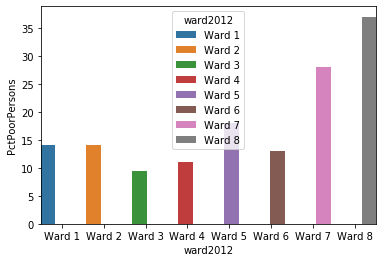

In [78]:
#Plotting average family income across wards

fig, ax = plt.subplots()
sns.barplot(x="ward2012", y="PctPoorPersons", hue="ward2012", data=income)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        #changing the bar width
        patch.set_width(new_value)

        #recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)
plt.show()

Let's look at the income statistics:

In [139]:
#Visualizing average family income with a choropleth:
ward = r'dc_ward_overlay.geojson'

income_map = folium.Map(location=[DC_LAT, DC_LON], tiles='CartoDB positron', zoom_start=11.5)

#folium.GeoJson(ward, name='geojson').add_to(pct_map)

folium.Choropleth(
    geo_data=ward,
    name='choropleth',
    data=income,
    columns=['ward2012', 'AvgFamilyIncAdj'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Family Income'
).add_to(income_map)

folium.LayerControl().add_to(income_map)

income_map

In [134]:
#Saving map to HTML:
income_map.save('income_map.html')

Looking at the income map, we can see that there are massive differences between the wards, specifically those east of the Anacostia. Let's plot this with Seaborn:

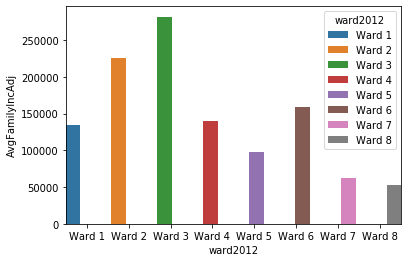

In [74]:
#Plotting average family income across wards

fig, ax = plt.subplots()
sns.barplot(x="ward2012", y="AvgFamilyIncAdj", hue="ward2012", data=income)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        #changing the bar width
        patch.set_width(new_value)

        #recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)
plt.show()

Given the visualizations we made with above, we'll examine wards 7 and 8 and select the corresponding data from our results to plot them.

In [131]:
#Filtering our results for locations in wards 7 and 8 only:

ward_areas = results[results['Ward'] >= 7]
ward_matrix = ward_areas[['Venue Latitude', 'Venue Longitude']].as_matrix()
ward_n = neighborhoods[neighborhoods['WARD'] >= 7]

/Users/jonathandesteuben/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [137]:
#Visualizing venues:
ward = r'dc_ward_overlay.geojson'

area_map = folium.Map(location=[DC_LAT, DC_LON], tiles='CartoDB positron', zoom_start=12)

folium.GeoJson(ward, name='geojson').add_to(area_map)

for lat, lng, name, ward in zip(ward_n['LAT'], ward_n['LON'], ward_n['NAME'], ward_n['WARD']):
    label = '{}, Ward: {}'.format(name, ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.7,
        parse_html=False).add_to(area_map)

area_map.add_children(HeatMap(ward_matrix, radius=35))
 
area_map

/Users/jonathandesteuben/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [138]:
#Saving map to HTML:
area_map.save('heat_map.html')

We can see from the resulting heatmap that there a few neighborhoods where medical facilities are out of proximity: 

* **Benning Ridge**
* **Marshall Heights**
* **Deanwood**
* **Kenilworth**
* **Lincoln Heights**
* **Greenway**
* **Capitol View**

This concludes our analysis section.

## Results and Discussion

Based on our analysis, we've determined a group of neighborhoods that would be the best choices to add increased medical services and facilities. Given the demographic information that we used in the analysis stage, we determined that these neighborhoods are lower income and have higher percentages of unemployed persons, which we believe should be given higher priority based on their need.

By the end of the project, we were able to pinpoint these neighborhoods. We can present this new information to different stakeholders as a public insterest project that can benefit underserved areas in the city that don't have any medical facilities to serve their populations.

## Conclusion

In this project, our goal was to use the data science skills learned in Coursera's IBM Data Science course to find areas in Washington D.C. to find areas that would benefit from additional medical facilities. Using open data, previous course material, data visualization packages, and other resources, we were able to apply a solution to our problem using data.